In [1]:
from urllib.request import urlretrieve
import os
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline  

URM_file = open(r"C:\Users\aless\PYTHON_NOTEBOOKS\RECOMMENDER_CHALLENGE\data_train.csv", 'r')

def rowSplit (rowString):
    
    split = rowString.split(",")
    split[2] = split[2].replace("\n","")
    
    split[0] = int(split[0])#userID = row o forse row+1?? Dipende da come pensiamo id
    split[1] = int(split[1])#itemId =column
    split[2] = int(float(split[2]))#rating IMPLICIT
    result = tuple(split)
    
    return result



URM_file.seek(0)
URM_tuples = []
URM_file.readline()#questa è importante di cristo c'è riga di introduzione
for line in URM_file:
    URM_tuples.append(rowSplit (line))


#ora devo costruire saggiamente la matrice


data = np.array(URM_tuples)
#print("Numero di rating:"+str(data.shape[0]))
#crea URM
result = np.zeros((data[:,0].max()+1, data[:,1].max()+1), dtype=int)
result[data[:,0], data[:,1]] = data[:,2] 

userList=set(data[:,0])#significa tutte le righe considerando solo la colonna 1
itemList=set(data[:,1])
ratingList=data.shape[0]

print("Num Utenti: "+str(len(userList)))
print("Num Items: "+str(len(itemList)))
print("Num Ratings: "+str(ratingList)) #sarà righe-1 di itnestazione
print(result.shape)#forma della matrice 


import scipy.sparse as sps

URM_all = sps.coo_matrix(result)
URM_all = URM_all.tocsr()

Num Utenti: 7947
Num Items: 24896
Num Ratings: 113268
(7947, 25975)


In [4]:
from Notebooks_utils.data_splitter import train_test_holdout
from Notebooks_utils.evaluation_function import evaluate_algorithm
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python


URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)#sono traine test locali,aka train e valiation
#-----------------------------------------------------------------------
#-------------------------STUFF-----------------------------------------
#-----------------------------------------------------------------------
from Base.Evaluation.Evaluator import EvaluatorHoldout
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])#perchè ne voglio solo 10 suppongo

class UserKNNCFRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        
        scores = self.W_sparse[user_id, :].dot(self.URM).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

## Prameter tuning


UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 3460.34 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 5640 ( 100.00% ) in 3.08 sec. Users per second: 1833
Numero di Neighbours= 10 MAP= 0.039452734674444996

UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 3392.18 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 5640 ( 100.00% ) in 3.30 sec. Users per second: 1710
Numero di Neighbours= 50 MAP= 0.053610165702411686

UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 31

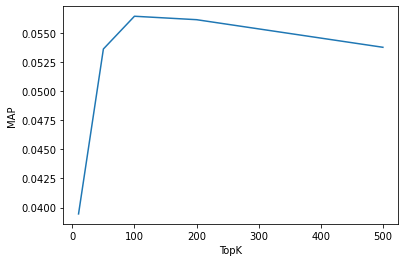

In [8]:
#importa roba nuova per fare recommendation non so perchè 
from KNN.UserKNNCFRecommender import UserKNNCFRecommender




x_tick = [10, 50, 100, 200, 500]#100 è il top
#x_tick = [100]#100 è il top
MAP_per_k = []

for topK in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_dict[10]["MAP"])
    print("Numero di Neighbours= "+str(topK)+" MAP= "+str(result_dict[10]["MAP"])+"\n")
    
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 3270.32 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 5640 ( 100.00% ) in 3.41 sec. Users per second: 1653
Shrink term= 0 MAP= 0.05642181527851481

UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 3154.26 column/sec, elapsed time 0.04 min
EvaluatorHoldout: Processed 5640 ( 100.00% ) in 3.66 sec. Users per second: 1539
Shrink term= 1 MAP= 0.05628519161801839

UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 3087.01 column/sec, elap

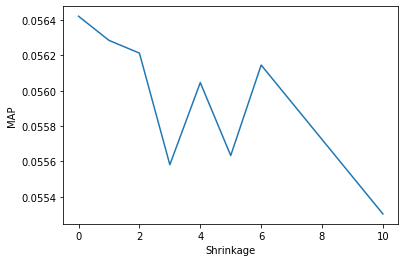

In [9]:
x_tick = [0,1,2,3,4,5,6,10]#0 e 1  top
#x_tick = [3]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_dict[10]["MAP"])
    print("Shrink term= "+str(shrink)+" MAP= "+str(result_dict[10]["MAP"])+"\n")
    
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

In [10]:
recommender = UserKNNCFRecommender(URM_train)
recommender.fit(shrink=0, topK=100)
    
result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
MAP_per_shrinkage.append(result_dict[10]["MAP"])
print("Shrink term= "+str(shrink)+" MAP= "+str(result_dict[10]["MAP"])+"\n")

UserKNNCFRecommender: URM Detected 73 (0.92 %) cold users.
UserKNNCFRecommender: URM Detected 2374 (9.14 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 7947 ( 100 % ), 2934.49 column/sec, elapsed time 0.05 min
EvaluatorHoldout: Processed 5640 ( 100.00% ) in 3.49 sec. Users per second: 1616
Shrink term= 10 MAP= 0.05642181527851481



In [13]:
class UserKNNCFRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        
        scores = self.W_sparse[user_id, :].dot(self.URM).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [16]:
recommender = UserKNNCFRecommender(URM_train)#provo a cambiare con URM_all
recommender.fit(shrink=0.0, topK=100)#è questo quello bello lento!!

import time

n_users_to_test = len(userList)

start_time = time.time()#BUONE METRICHE PER IL TEMPO QUI

for user_id in range(n_users_to_test):
    rec=np.array(recommender.recommend(user_id, at=10))
    #srivo rec
    print("raccomandazioni per utente "+str(user_id)+str(rec))
    #print("\n")
end_time = time.time()
print("Ha finito in questo tempo: "+str(end_time-start_time)+" secondi")




Similarity column 7947 ( 100 % ), 3059.94 column/sec, elapsed time 0.04 min
raccomandazioni per utente 0[ 1447  6915  5161 25878 15708 20761 14462 23481 13219  8544]
raccomandazioni per utente 1[19089 17723 23600 20095  5044 19480  8894 17257 12409 18317]
raccomandazioni per utente 2[13144 17264  2879 25491  8374 22234   655 15835  1197 14359]
raccomandazioni per utente 3[22487 24075  3942 18569 17820  3677 11341  2074  5412 15550]
raccomandazioni per utente 4[ 1611  9243 18692 12474  8544 11076 17024 13427 10979 15327]
raccomandazioni per utente 5[ 8097  8322  5078  4878 11695  8709  7013 11535  8089 21257]
raccomandazioni per utente 6[24383 25044 17252 10745  1282 23906 18173  9056  6299 15176]
raccomandazioni per utente 7[ 4209 23568  1358 17305 11159 23155 23267  9018 20148 24410]
raccomandazioni per utente 8[25407  6878  1583 23154 10594  7727  6734  2426 16928 24069]
raccomandazioni per utente 9[ 8877 23608 10132 19792 20666  6076  3891  1943 19049  5146]
raccomandazioni per uten

raccomandazioni per utente 155[ 4620 20496 23536  9258 12365 13118 14433  3599 16552  1656]
raccomandazioni per utente 156[10594  9555 23154  1583 10981 18452 10834  7727 16928 16906]
raccomandazioni per utente 157[ 9475 18317 14820  4204    68 21895 17304 24687  2274  5870]
raccomandazioni per utente 158[ 5150 17546 15196 17517 18367 15234  7568  9511  5641  5844]
raccomandazioni per utente 159[18687  4447  3037 20919 14723 23658 23844 22151 22829  3785]
raccomandazioni per utente 160[12601 21355 25738  5930  4871 19033 11197   679 22731 25133]
raccomandazioni per utente 161[19401 24146 19564  9341 25693  2533 16420 15592  2678 22750]
raccomandazioni per utente 162[18293  3473  6039 10491  9690  9684 22710 13628  8944  6717]
raccomandazioni per utente 163[ 4940  2459 20308  6291 18541  1863  8395  6952  4502  8560]
raccomandazioni per utente 164[25407  4878 11535 17819 14706  1577  7013  8322 20095  8089]
raccomandazioni per utente 165[ 5717  7639 20148  8524  4209 24410 21552 13219 1

raccomandazioni per utente 329[14684 18512 18419 19874 11832 14534 24355 20308 10418  6612]
raccomandazioni per utente 330[ 9438 10269 22554 12061 10786 18293  5942  9851 25407  3803]
raccomandazioni per utente 331[ 5187   592 23153 16266 11734 12154 15183  4815 23749  3132]
raccomandazioni per utente 332[12273   817 23481 20290 21552 23799 14291  5078  2197 17525]
raccomandazioni per utente 333[23536 11792 23711  2868  9284 18190  5717 15459  6088 12341]
raccomandazioni per utente 334[11723   453  7508 15663 22591  8097  9168 14920 15197 18964]
raccomandazioni per utente 335[ 9851 11792  9315 25675 13541 12341  9029  5717 16552 15327]
raccomandazioni per utente 336[14684 17668 19874 18512  4502 10418 24355  2274  2159  4257]
raccomandazioni per utente 337[18704  7662 12889  1389 10399  7728 20016 19985 19282 11191]
raccomandazioni per utente 338[10939 15729 15795  4841 17229  6734 14744  8886 11628  3013]
raccomandazioni per utente 339[11340  9733  4980 24070 22655 12050 11991 16394 2

raccomandazioni per utente 474[ 7222  4742  3612  8869 17481 23766 19547 16624 22749  3931]
raccomandazioni per utente 475[17723 23600 19089 19709  7494  8894 13490 20146 24355 19480]
raccomandazioni per utente 476[20545 11135 24830 12440  7792 16607 16857  2510  5934  7211]
raccomandazioni per utente 477[ 3971   471  6279 11504 15257 24962  7117 21704 22327  3418]
raccomandazioni per utente 478[17424 20944 22226  8660  8649  8650  8651  8652  8653  8654]
raccomandazioni per utente 479[22548 18793   497 15559  7267  9662  9769 12158 13424 15234]
raccomandazioni per utente 480[ 7709  1479 21947 12033 24735 25424 22500 19378 23074  5317]
raccomandazioni per utente 481[11533  2118  5952  3580 20974  4541  6212  1573 20863 13586]
raccomandazioni per utente 482[ 8560  1863   921  9386 19049  9591  4912  6088  5965  8920]
raccomandazioni per utente 483[ 2333  4620 23536 23711 18190 24075  8285  5717 11792 19588]
raccomandazioni per utente 484[15691  9555  2426 10834  1583  6734 10594  9701 1

raccomandazioni per utente 648[ 2840 22730  3625  6843  6351 14684 14534 19874  8395 20308]
raccomandazioni per utente 649[ 4456 25897 19871 22653 13922  2232 11150 22314 15865 11432]
raccomandazioni per utente 650[23873  4458  8084 22829 14723 24132 11012   974 11638 16906]
raccomandazioni per utente 651[ 9438 10269 25675 19709 20146 23600  2426  5044 15564  2665]
raccomandazioni per utente 652[ 8560  1863 18122  9591  9018 13628 15906 12801 21552  6632]
raccomandazioni per utente 653[19089 19709  7494 20095 12409 20146 11687 14291 16630  6198]
raccomandazioni per utente 654[  839 25478   613 12061 23568 18380 19704  9102 10786 13112]
raccomandazioni per utente 655[11340 12050  4980 13136  2426  8316 17156  8309     5 23154]
raccomandazioni per utente 656[16904 11388 18760  7980  8700  4209 13967 11253 25896  8473]
raccomandazioni per utente 657[16805 22645  5817 21464 19342  2868  2996 25548 21859 19108]
raccomandazioni per utente 658[15113 19393  8251 19049 22686 14978 10818 13560 2

raccomandazioni per utente 816[ 1863 21552 19094  5504  2996  9591  6755  5717 15906 22511]
raccomandazioni per utente 817[ 6612 24075   851 19908  2127 14806  8291  5491 20083  3418]
raccomandazioni per utente 818[14951  1753 25674  8740 22121  7405 11295 20146 11642  5587]
raccomandazioni per utente 819[ 3497 25407  8529 22554 11381 24075  3867  3115  1294  8436]
raccomandazioni per utente 820[16150  3996  2426  7307  4841 17143 22236 18282 10594  9555]
raccomandazioni per utente 821[ 4147 21061  3744 10889  7550  5469 10983 14141  1064 20422]
raccomandazioni per utente 822[ 1573 18574 22848 23154 10834  9446 20087 10081 12844 15595]
raccomandazioni per utente 823[13797  4773 13878 11280 24015  6035 19241 24748 20290  6872]
raccomandazioni per utente 824[13541 23536 18190 21854 15459 12341 11792  2333  6088 15327]
raccomandazioni per utente 825[15764 18569  8064  8304  4803 18122  3997 17820  5412  3068]
raccomandazioni per utente 826[ 4502 18419 17668  7450 16116  2232 10418  6970 1

raccomandazioni per utente 967[ 8709 15182 13993  4936  5032   497 18793 20300 15559 11975]
raccomandazioni per utente 968[11622 20746 16897  4215  6446 13490  5475  8955 15196  4824]
raccomandazioni per utente 969[19874  4502 24355 20308 17668  8395   359 18419 17637 18512]
raccomandazioni per utente 970[14418  9218  2333  6088 22359 13541 23536 23711 15459 10789]
raccomandazioni per utente 971[ 9085 23975 12943 16577 13433 23044 13278 16630 11925 20850]
raccomandazioni per utente 972[ 5717 18190 21464 23536  3337  2333 13541  3601 23666 21971]
raccomandazioni per utente 973[15067  8544 10248 10295  1720 25520 13224 20934 25676 15830]
raccomandazioni per utente 974[25171  2570  2426 14141  6831 23001 25898  5108  1583 18392]
raccomandazioni per utente 975[25407 20095 12602  5044  1240  2236 12914 19709 22121 19089]
raccomandazioni per utente 976[ 8097 24577  9370 21042  5930  6097 11812 23758  3913 20238]
raccomandazioni per utente 977[14684 19874  4502 24355  4257 11737 18512 16324 1

raccomandazioni per utente 1115[12719  7728  1307 22554 19468  4878  4421  2426 12538 23985]
raccomandazioni per utente 1116[ 5685  7165 18552 22980 17329 19676  2787  5268   438 24097]
raccomandazioni per utente 1117[ 5185 24230 19620 21552 18293 25046 12923 18419 23485 22448]
raccomandazioni per utente 1118[ 8727 23146 19136 24281 10346  2036 22135 16938 15256  9737]
raccomandazioni per utente 1119[14684 14640 19874 20148   386 16651  5994  2665 23600  3930]
raccomandazioni per utente 1120[ 3787  6844 20308 23858  4502 11708 25908 11452 12829 11085]
raccomandazioni per utente 1121[ 4063  2275 20194 24355 25407 25675  1818 19730 12135 23305]
raccomandazioni per utente 1122[11540  6069 23741 11802   471  4584  7594 22043  5501 15501]
raccomandazioni per utente 1123[17680 23737 22438  8388  4737 14672 25587  2421  2125 23255]
raccomandazioni per utente 1124[ 5717 23711  4620 15327 11792 18114 23536  8285 15459 21583]
raccomandazioni per utente 1125[13763  5084 17586 25083 25702 13388 19

raccomandazioni per utente 1289[ 1863 21552  1947 22645  4940 15764  8064  8560 24075 24093]
raccomandazioni per utente 1290[20404  6828 12343 11061 12685 20252   876 23100  7839 20982]
raccomandazioni per utente 1291[14684  1714  4257 20308  7883 24355 19874 18419 20553  6612]
raccomandazioni per utente 1292[19114  8544   454  2300 10786 18190 18176  7639 15327 23711]
raccomandazioni per utente 1293[25675  3551 25407  9438  9591 10979 14978 24075 16972 19282]
raccomandazioni per utente 1294[13020  8446 11645 19857 10853 15176 11969  3536 25807  8842]
raccomandazioni per utente 1295[  681 22121 13703  4824  2995 13887  6878 16443 16758 25927]
raccomandazioni per utente 1296[ 2258  9018 12013 23175  4801   537  8095 21288 16077  6899]
raccomandazioni per utente 1297[ 5178 22500 20308 24358 24209 13740 13663 11112  7494  6612]
raccomandazioni per utente 1298[10418 19874 15754  4502  1714 16926 10372 24663 20191  2459]
raccomandazioni per utente 1299[22440 11695  9591  4966 21552   661 18

raccomandazioni per utente 1445[14356 10162 12254 22121 16793 10653 24274  4390  4588 16772]
raccomandazioni per utente 1446[13508 18060  7965 14354 18859  7115  2572  8529  5571 25676]
raccomandazioni per utente 1447[12061 20934 12948  9947 24472 10675 24850 14483 14462  4811]
raccomandazioni per utente 1448[ 8826 16420 10586  1307 17379  4237 24908  7985 17455  9438]
raccomandazioni per utente 1449[ 8544 10786 21552 13118  9438 25675 20496 10269 11792 24410]
raccomandazioni per utente 1450[20122  4856 19935  9438   689 17808 13170 15363  8732 23563]
raccomandazioni per utente 1451[16124 19007 18852  4346 13433 18547  1700 16011  5283  7283]
raccomandazioni per utente 1452[14912 15313  4620 24884 11868  1834  6088  2333 15459 13987]
raccomandazioni per utente 1453[ 2641   878 25353 11987 22300  9797   562 16065  3835  9282]
raccomandazioni per utente 1454[  837 19295  3541  2889 19903  3036  1591 12732 23435 16268]
raccomandazioni per utente 1455[10162 13226  2001 20688 14356  4588 15

raccomandazioni per utente 1582[ 2678  1307 12538 14382  8990  2235 12755 17465 17156 24075]
raccomandazioni per utente 1583[ 7886 22407 16380  5178 23984 18345 13090   716   640  3514]
raccomandazioni per utente 1584[24075  7568   194 18222  8065  3971 12638 12142 18093  9531]
raccomandazioni per utente 1585[ 3744 21061  4147 13887 16577  1869  7550  5469 14141  5763]
raccomandazioni per utente 1586[12876 12244 20662 24173  7690 21035 24962  3418 22327  7117]
raccomandazioni per utente 1587[25539 25347 25044 20834  8424 15161 14962 22261 15681 25711]
raccomandazioni per utente 1588[18262 14684 11114 19436 24355  6500 20308 19213 21470 18915]
raccomandazioni per utente 1589[ 9438 25209  9135  8475 12230  9379  8854 17470  3094 15333]
raccomandazioni per utente 1590[20146 19709  8097  7494 20095  7115 10908 11687  9620 12389]
raccomandazioni per utente 1591[ 9555  6734  2426 23154 18392 17156 13711 22848  1583 16928]
raccomandazioni per utente 1592[ 9438 25675 24075 22554 10269  8538 20

raccomandazioni per utente 1733[ 3580 16324  8396  5664 16218 25868 18624 17370  4213  7412]
raccomandazioni per utente 1734[15234 11452  5179    25 15903 24355 20176  8456 22277  9358]
raccomandazioni per utente 1735[19875 25596  2118  9733  3737 13663 15169 11991 20863  6212]
raccomandazioni per utente 1736[12486 12703 25675   894 15877 18194  9963 25407  5669  9551]
raccomandazioni per utente 1737[ 7851 12158 13294  8558   292 24655 25912  8990  7961 22372]
raccomandazioni per utente 1738[13686 24255  1211  8987   968 17745   617 14253 11357 19220]
raccomandazioni per utente 1739[ 4620 13541 15459 12341  6088 11803 18190  5396 15327  9029]
raccomandazioni per utente 1740[ 3668 13764 16112 11741 14220  5489 11987  4528  3469  9797]
raccomandazioni per utente 1741[  191 19468  5218 22372  2837  8097 21042  9992 11628  1436]
raccomandazioni per utente 1742[24093 24484 18122  8304  4803  8064 18569 10807 18925 24109]
raccomandazioni per utente 1743[ 3045 10609 22453 24844 25974  8661  8

raccomandazioni per utente 1876[19118  9591 18122 20980  9535 15881 22845 23230 19824  5965]
raccomandazioni per utente 1877[ 3768 20301 10420 25129  6011 18373  5063 11221 13437  1660]
raccomandazioni per utente 1878[13561 25897 19871 22653 14684  2732  2232 11150 22314 21606]
raccomandazioni per utente 1879[19252 16200  9787  8403  6443 15285 18778 18674  3449  9760]
raccomandazioni per utente 1880[24075  9438 22554 10786  4512 12923  5942 10269  9851 12061]
raccomandazioni per utente 1881[25596  4502  3737 11533 20308  3580 13586 24481 25080 15169]
raccomandazioni per utente 1882[ 7728  5078  6632 11459 22554 21469 16902 23985 13465  4631]
raccomandazioni per utente 1883[14684  4502 20308  6612 19874 10418  4257 18399 24075 11114]
raccomandazioni per utente 1884[ 6018 23071  5686 20161 16519  1710 25354 17563  9352 10269]
raccomandazioni per utente 1885[19062 20290  7639 16471 19167 17503  2759  1398  9943 21552]
raccomandazioni per utente 1886[25596  2789  9899 14485  7086 20063 16

raccomandazioni per utente 2023[25675 22554  9438  9851  4512  6632  3803 12061  6294 21552]
raccomandazioni per utente 2024[13226 23651   484 17013 23468 20688  6655  5497 10590 11830]
raccomandazioni per utente 2025[13764 10979 12289  9732 21552  7115 23310 20934 21493  4966]
raccomandazioni per utente 2026[15714  7601 19480 11730 10979   525  6198 18293  1863  6905]
raccomandazioni per utente 2027[22359  3668  2333 12293  8544 14418  9851  6016 25903 23457]
raccomandazioni per utente 2028[19089 19792 11900 10035 23481 20979  6076 10537 18475 14383]
raccomandazioni per utente 2029[14684  4502 17668 19874 20553  4257  6208 18419 19879 24481]
raccomandazioni per utente 2030[22128 18293  6294  5185 25524 22554 15678   942   466 18804]
raccomandazioni per utente 2031[14488 13424  3456 13502 14315 25118  8558   557  1696 16939]
raccomandazioni per utente 2032[  561 19620  7883 11673  2788 16394 21512 24070 14626 17858]
raccomandazioni per utente 2033[23006  7865 14024  9630 13485 24481 21

raccomandazioni per utente 2189[ 7144 25083  5150  5772 15903 25712 10766  1240 15196  7568]
raccomandazioni per utente 2190[20146 15714  7601  8251 19480 11730 20095 21583 17257  8316]
raccomandazioni per utente 2191[   84 25101  9438 25693  7494 18881 24075   964  1055 24699]
raccomandazioni per utente 2192[ 9290 19709 17858 20095 23600 12409  9047 13000 12948  6198]
raccomandazioni per utente 2193[14672  3631  3660 20308 14333  1092 23171 13157  6936 20269]
raccomandazioni per utente 2194[ 6767 18872 13630  4620  3236 24340  8285 20261 16083 15027]
raccomandazioni per utente 2195[17637  2459  5078  9942 20345 18310 20553 18512 12037 22485]
raccomandazioni per utente 2196[21948 21699 22588 21630 24384 19704 15759 19833 12983 24722]
raccomandazioni per utente 2197[ 8158  5562  8145 24075   817 14609 19398 10269  2109 25736]
raccomandazioni per utente 2198[24075 16218 24355  5942 25693 14038  8059 21552 20308   180]
raccomandazioni per utente 2199[24230  7583 18174 17879  7810   491  6

raccomandazioni per utente 2331[25675  9438 19401  3803 22554 18293 10421 14595 11900 21552]
raccomandazioni per utente 2332[ 2665 22121 12466  5744  5044 19089 21049 10792 11091 16629]
raccomandazioni per utente 2333[25407 23154  2426  8316 10834  7727 12050 11991  6327  5952]
raccomandazioni per utente 2334[23600 19709 20146 20095 19480  2665 23481  7494 12409  8894]
raccomandazioni per utente 2335[24075  9438 18293 12923 14595  4512 10786  3803 25260  1842]
raccomandazioni per utente 2336[13763  8242 11871  3485 25170 25083 10747 13742 19518   592]
raccomandazioni per utente 2337[25675  9438  5942  9851 10786   773  8538 22554 13118 18293]
raccomandazioni per utente 2338[23979 18353 12443 19866 14839  7868 24250 25183  4680 10634]
raccomandazioni per utente 2339[24069 25827 21761 23273  4413 22121 19427 25109 15234 13118]
raccomandazioni per utente 2340[10406  2969 18285 22121 22335   581  1203 25101 21114  3539]
raccomandazioni per utente 2341[11533 19875 25596  8860 22801  5032  3

raccomandazioni per utente 2496[10594 25407  2426  9555 10792  6734 10834 23154 17249   861]
raccomandazioni per utente 2497[10269  8706 18324 15903 18778  5330 25223 13686  6974 18149]
raccomandazioni per utente 2498[10269  9438 12061  1888 25675  5044 12550 11730  2839 18293]
raccomandazioni per utente 2499[20807  8541 20934  9239   132  3196 17710  2811 14291 22771]
raccomandazioni per utente 2500[ 5760 18747 22065  8316  9321 10727 15691 23865  7389 18451]
raccomandazioni per utente 2501[ 9050 10789 25903 11792 14418 20130 22646 12293 12550 21890]
raccomandazioni per utente 2502[14839 10752 14625 23115 25183 23374  6861   510 19488 13578]
raccomandazioni per utente 2503[24355  2972  7984  5179    48  5155 20624 23741 19357 22853]
raccomandazioni per utente 2504[22392 25974  8662  8653  8654  8655  8656  8657  8658  8659]
raccomandazioni per utente 2505[ 5680 12789 13865 17427  7243 15778  4218 17843  8843   974]
raccomandazioni per utente 2506[20969  1242 19468 12601  9992  6446 20

raccomandazioni per utente 2649[18392  7095  2492 23141 16738   114  3832 13711 16615 11340]
raccomandazioni per utente 2650[20654 11727 10450 16552 25459  6362 14717 23457 18864  6088]
raccomandazioni per utente 2651[12206  2198 16394 22145  7288 19229  4768  8547 16460  5244]
raccomandazioni per utente 2652[ 3570 25814 13541  5539 16083  8920  1863 14373  2980  6936]
raccomandazioni per utente 2653[ 8052 12627   615 23020 10273  9438  3931 18925 12230 21799]
raccomandazioni per utente 2654[16301  3037 11855 16871 19776  7030 17724  7662  8790  8709]
raccomandazioni per utente 2655[18512  2819 17305 20975 17326  2366 22885  5870 12320 24355]
raccomandazioni per utente 2656[ 4620 15459 18190 13541 12341  6088  2333  9029 23457  5396]
raccomandazioni per utente 2657[23711 12061 14713  9050  3236  1209 18331 22359   962  3469]
raccomandazioni per utente 2658[ 6691 24943  7883 10073  9690  7837 11091 11658   806 19480]
raccomandazioni per utente 2659[ 4257 14684  4502  6010 24075 18357 14

raccomandazioni per utente 2810[13541 23536 18190 12341  2868  2333 15327  9029  9284 21854]
raccomandazioni per utente 2811[13432  8887 20014   747  9433 15010  8544 10386 18160 20978]
raccomandazioni per utente 2812[18512 14684  8769  8395  4502 20308 17229 24481 12309 14744]
raccomandazioni per utente 2813[18715   349 11501  8578 17209 13663  9733 11340  8316 16394]
raccomandazioni per utente 2814[25675  9438 10269  5728 24314 25757 24075 10320  6374 19840]
raccomandazioni per utente 2815[17760 20108 14376  3337 11792 11040 19910  8158 12710  8910]
raccomandazioni per utente 2816[19874 20368 18419  4502  9657 25760 14684  4911  6691  8268]
raccomandazioni per utente 2817[ 3293 15067 10248 25520 13224 25676 20934  4433 20148  8544]
raccomandazioni per utente 2818[ 5717   454 11792 13837 21854 15327  5119  2432 18190  4811]
raccomandazioni per utente 2819[14684  6612 20308   814  4502 17668 18512  1055 11114 15234]
raccomandazioni per utente 2820[ 6995   359 15358 25957 19933  4892 17

raccomandazioni per utente 2963[19781 20897 11518 18692  9243 25675  1377   867 21365 14548]
raccomandazioni per utente 2964[20345   359 17637 24711  2570 21332  2835  8395 11700 16150]
raccomandazioni per utente 2965[10834  6734 17156 17209 13711 21920 10345 10908 23133 11533]
raccomandazioni per utente 2966[23410 21680  8158 19480 14978  6239 21518 20122  2476   817]
raccomandazioni per utente 2967[10594 25407  6734 17156 10792 15691 18392 13711 10901  9555]
raccomandazioni per utente 2968[19089 11687 25873 23600 19525  7896  8431   364 20095 10841]
raccomandazioni per utente 2969[ 5092  4102 13175 14281  1358  4203  4834 18730  7878 19911]
raccomandazioni per utente 2970[10009 11792  8524 14311  9851 20496 14023 22511  3724 23536]
raccomandazioni per utente 2971[14104  4078 15309 14300 16355 13353  8475 25693 13796 17759]
raccomandazioni per utente 2972[ 2001 23651   484 20688 10162 16793 21021 22226 19799  6446]
raccomandazioni per utente 2973[ 8097 19709  8709 12914  1240 13294  8

raccomandazioni per utente 3121[20841  3971 19511  7568 17218 17546  4809 21116 16577 25314]
raccomandazioni per utente 3122[ 9851 22554 10269  5942 12061 19564  4512 14291  8538 15034]
raccomandazioni per utente 3123[23651 13226 20688 23468 10162 16793  9555 21021  6446  8272]
raccomandazioni per utente 3124[22359 14418  7075 22128 15714 13797  9851   110 25524 12293]
raccomandazioni per utente 3125[24586 17407 25974  8660  8651  8652  8653  8654  8655  8656]
raccomandazioni per utente 3126[ 9591  8920 21552 22645 20711  4940  8560  4966  9348 23536]
raccomandazioni per utente 3127[ 2641 12742   141 19079  4620  6674  3835 13837   562 13541]
raccomandazioni per utente 3128[10391  3583  6868 25020 19891   984  2491  3867 21754 14362]
raccomandazioni per utente 3129[21857 20553 17668 24355 21697 17662 18512  8544  9327 22511]
raccomandazioni per utente 3130[15778 24549 15257 23560  3485 11362  7244  4502 15636  1705]
raccomandazioni per utente 3131[25407 10594 23154 10981 22010  1583  2

raccomandazioni per utente 3270[ 1846 24429 14485  5218 17717 25407  7086 25430  3230 10889]
raccomandazioni per utente 3271[ 4956  4237  6123 15988 18510 20226 17952  2656  5259  5156]
raccomandazioni per utente 3272[24075  9514 25260 16394  7228 16577 16214  2426  1463 22554]
raccomandazioni per utente 3273[18293  6294 18804  5380 18443 12875 22991  8590  6632 15915]
raccomandazioni per utente 3274[14769 21492 16382  6461  5870  1009  7388  2059  7851 10245]
raccomandazioni per utente 3275[16362 10185  5989 17629 23634  8650  8651  8652  8653  8654]
raccomandazioni per utente 3276[15379 15273  6518  6555 15022 11979 23945 19908 12533 14131]
raccomandazioni per utente 3277[10594  2426  1583 15691  7991 17156 23141  9322 22848  8316]
raccomandazioni per utente 3278[25675 10786  5942  9851 18293 10269  8538 13118 19401 25260]
raccomandazioni per utente 3279[20464 18149  1743 19792    41 16262 19429 19089  2122  3257]
raccomandazioni per utente 3280[20146 19089 17723 23600 20095 19480 17

raccomandazioni per utente 3418[24297  7879 23842 17168  9578 14715  8718  8648  8650  8651]
raccomandazioni per utente 3419[16577 12943 12601 16772  9607 11197  4632   306 25133  8428]
raccomandazioni per utente 3420[ 8709 12158 15650 19089 17586 12549  8738 24995   969 19709]
raccomandazioni per utente 3421[17452 24075 11792  9438 25865 25675 16005 23457 19114 10363]
raccomandazioni per utente 3422[12293 13541 20130  6088 11792 25903 23711 18190 23536 16552]
raccomandazioni per utente 3423[25407  1583  9555 10834  2426 23141 16928  8990  7991  7095]
raccomandazioni per utente 3424[19089 23481 19709 14291 11687  7494  8251 19524 20095 20146]
raccomandazioni per utente 3425[ 6208 14684 18419  3037 15903 24355  4502  2274 11533 25407]
raccomandazioni per utente 3426[14104   341  1205 16801 19427  8616 19793 16932  8805 10975]
raccomandazioni per utente 3427[ 5952  3737 12538 20863  6878 10569 22731 16918  6708  8990]
raccomandazioni per utente 3428[16726 23405 15733 25034  3579  2798 24

raccomandazioni per utente 3575[18122 18619  2463 22845 19480  1852  8811 11730 24075 20562]
raccomandazioni per utente 3576[ 3735  9315 20301 16150 21774 21608 24607  3804  9845 21192]
raccomandazioni per utente 3577[ 4512 23888 14595  3803 18804 22750  5380  9438 25260  1842]
raccomandazioni per utente 3578[14863 21013 17320  5128  2438  2519 11342  3249 19695  6236]
raccomandazioni per utente 3579[14793 13424 11461 13231  6767 13559   772  7235 25335 18872]
raccomandazioni per utente 3580[16301 16871  8709  3281 15914 20919 23844 19577 14674 13954]
raccomandazioni per utente 3581[ 3202 16258 14257 15248 10357  8304 24093  3138 19692 19756]
raccomandazioni per utente 3582[18293 16394  6208 14684 12214  9683 15903  5032  4940 25827]
raccomandazioni per utente 3583[ 7583 19875 12050 21257 22020 13611 22848 21373 19948 11533]
raccomandazioni per utente 3584[ 5337  9984  3234  3165 13433  3778 16552  3964 20802  8517]
raccomandazioni per utente 3585[23671 24685 10801 11360 22359  4152  7

raccomandazioni per utente 3731[21492 13424 12194  1928  3550 23664 25430  7851  2497 24568]
raccomandazioni per utente 3732[12061  5717 23299  9029 11792 16503 10786 13541  9284  4620]
raccomandazioni per utente 3733[11871 25890 15636  3037 22256  8709 16489 15124  1230 24280]
raccomandazioni per utente 3734[21802  6616  1855 22739  7331  8416 14830 19654  4426  6257]
raccomandazioni per utente 3735[10796 20308 14684  1258 20669  5870 25479 18419 17668 24014]
raccomandazioni per utente 3736[ 1992 13078 25974  8652  8653  8654  8655  8656  8657  8658]
raccomandazioni per utente 3737[ 3497  5469 14141  1846 24429  3118   502   588  7232 12486]
raccomandazioni per utente 3738[22554 22750 18293 22991 23485 12923  3803  7202 11923   561]
raccomandazioni per utente 3739[21552 11792 18692 10530   477  8524 13730  4927 16176  1611]
raccomandazioni per utente 3740[22359  9050 13541 10789 17916 11792 12293 18768 25338 23536]
raccomandazioni per utente 3741[ 8860 17209 20974 25596  3737   349 11

raccomandazioni per utente 3865[13424 13231 14315  8558  8709 13502 12158 17512 16221 11478]
raccomandazioni per utente 3866[ 2135 19388 22300  6767 12478 14245  9337   921 25491 19353]
raccomandazioni per utente 3867[ 9851  4620  9050  1863  5717 24075 14166 18122 10786 23299]
raccomandazioni per utente 3868[21268 11991  2180  7467  8438  4019 15691  8316 25021 21123]
raccomandazioni per utente 3869[13207  9438 20024 22500 19328 25573 25199  6901  5942 25013]
raccomandazioni per utente 3870[15903 16775  7144 20514  8272 13424 25083 23651  2485 19535]
raccomandazioni per utente 3871[14433 18814 20750  3835 23799 22821 20093 20530 23127  4369]
raccomandazioni per utente 3872[10269 25675  9438 12061  5942 10786 25407 19089  1888 13118]
raccomandazioni per utente 3873[25974  8660  8650  8651  8652  8653  8654  8655  8656  8657]
raccomandazioni per utente 3874[ 9620 24577 10640   983 25407 21067  8097 20416  5044  7095]
raccomandazioni per utente 3875[24075 17059  7483 12467  7166 25463 20

raccomandazioni per utente 4006[19480 19709 24128 13845 19346 20095 17257 16630  3572 24355]
raccomandazioni per utente 4007[22570  3931  7544 19978 18728 25329  2398 14077  1146  7222]
raccomandazioni per utente 4008[18020  9821  1705  1320  4529 13386  7553 17334  2767   979]
raccomandazioni per utente 4009[19826 17668 20191 25711   992  4959 23757  2271 15657 18862]
raccomandazioni per utente 4010[20146  8431 12409 19792  2665 24209 16630  4512  7094 20982]
raccomandazioni per utente 4011[15650 18444 15642 11504 25138 15827  5364 25104  8200  3588]
raccomandazioni per utente 4012[ 8894 13923  2210  2610  7944 23799 11900 24865 19709 23608]
raccomandazioni per utente 4013[25793  9416 22536  9046 14727  5942  3192 25159  1268  7533]
raccomandazioni per utente 4014[ 8539  8593  1959  9752  5545 12329 22076 18612  9135 14137]
raccomandazioni per utente 4015[19781 21552 11731 11518  9243 15333 19450 24793   867 13654]
raccomandazioni per utente 4016[25974  8660  8650  8651  8652  8653  8

raccomandazioni per utente 4184[12409 23600 24128 20146  2665 21049 17723 16630  8894 10537]
raccomandazioni per utente 4185[25675 22554 13118  9851 12061 10786 19401  8538 12409  7494]
raccomandazioni per utente 4186[ 1564  5717 18114   454 20750 13541 11792 23536 21854 18190]
raccomandazioni per utente 4187[19089 16630 13294 11295 20095  2426  7063  6076  7494  3570]
raccomandazioni per utente 4188[21527  6239 23628  8158   817 14978  9438  5298 18300 24075]
raccomandazioni per utente 4189[ 6734  9322 10834  2426 15691 10594  5607 25407    15 17156]
raccomandazioni per utente 4190[13837 10428 24015  3668 15145  2641  3835 24437 19079 18114]
raccomandazioni per utente 4191[ 3037 12158  5032 16172   497  3815 18793 17370 24577 15559]
raccomandazioni per utente 4192[ 8665  9438 13332  5786 24147 14945  7494 25674 19332  7094]
raccomandazioni per utente 4193[ 3456  8558 14315 13502  5032 16939  8709 19339 20747  1885]
raccomandazioni per utente 4194[23799  8524  5581  3572  8560 10269 19

raccomandazioni per utente 4342[ 5717  5119 12061  4811  5906 12056 24911  8538 21653 23127]
raccomandazioni per utente 4343[22956  2154 25191 25716 21630  5998  6631 21385 13582 13168]
raccomandazioni per utente 4344[22985 13837  4052 11987 11859  7842  4627 19114  1913 21552]
raccomandazioni per utente 4345[ 3497  3744  4147 13294  1213  8850  7550 14141 21993 13805]
raccomandazioni per utente 4346[20063 13586  8344  4547  2426 24424  5053 11421 22798 16291]
raccomandazioni per utente 4347[ 5025 25675   394  1181 24792 10024 13424  7747 24075 16505]
raccomandazioni per utente 4348[ 7030 24794  1258 20290 16218 20919  5012 11669 15914 20700]
raccomandazioni per utente 4349[13552   341 24033 13433   913 24985  5284 20366  8475 13573]
raccomandazioni per utente 4350[15182   394  3037 20866  9066  5032 25675  1181 24792 10024]
raccomandazioni per utente 4351[24484 15764 13118 11397  8304 17382 12594 17820  6897 25693]
raccomandazioni per utente 4352[13381 10766  8886 20871 25352   194  9

raccomandazioni per utente 4521[ 2426 10834 25407 10594 17156  6734  1583  9555 15691 23141]
raccomandazioni per utente 4522[24484 24093  6897  8064   857 15764  3997  8304 15125 17284]
raccomandazioni per utente 4523[12082  2734 25439   762  2447  2300 21153   885 10821 10788]
raccomandazioni per utente 4524[25974  8660  8650  8651  8652  8653  8654  8655  8656  8657]
raccomandazioni per utente 4525[25596  3580 23154  3737 25407 22010 19875  2118  6212 20974]
raccomandazioni per utente 4526[11533 22010  9733  5952 11991  6878 11340 19875  3737 13136]
raccomandazioni per utente 4527[24075 10269  1863  7995  8811 24374 19049 23799 25407 13009]
raccomandazioni per utente 4528[ 5078 19655 11459 16324 17143 18939  1993 25407 22499  9320]
raccomandazioni per utente 4529[17960  4679 10331  9438 11474  7550 10660 22389 14412  9892]
raccomandazioni per utente 4530[ 3037  5032 18793 16172 15559   497  3815 25407 12158 15182]
raccomandazioni per utente 4531[12061 10786 11067 25675  6926 23711 20

raccomandazioni per utente 4652[14684  4502 20308 21629 17668 24355 17530  5207  6500  3643]
raccomandazioni per utente 4653[19033 25407 12601 19452 21042 21355  5044  5003 23141 20410]
raccomandazioni per utente 4654[13294 16651 14030  8840  7260  6797 15877 21228 23424  3744]
raccomandazioni per utente 4655[ 1863 22645  4966 13628  9591 22300 17705 24340  4625 13541]
raccomandazioni per utente 4656[21619  2388 18367 18951 10766 15686 18222 18184 23022 13134]
raccomandazioni per utente 4657[11383  8529 22736 20844 17252 18452 23987 12081 10074 12466]
raccomandazioni per utente 4658[17668 10073 11033  3508 18419  1436 20778 18574 11362 22655]
raccomandazioni per utente 4659[ 8097  4878 16772 12466 19750 25407 24577  5044  1240 17819]
raccomandazioni per utente 4660[24355 20368  6612 19874 14684 10418  7913 11033 20553 18512]
raccomandazioni per utente 4661[ 5717  9851 12061 13541 24075  4620 18190  6088  9284  9438]
raccomandazioni per utente 4662[ 5078 11459  2570 20375  9320 16324 17

raccomandazioni per utente 4765[12313 25693 18790 19899  5494  5273 17115 16220 19114  4927]
raccomandazioni per utente 4766[24075  8229 16266  7426 21364 25702  5044 21674  5084 18515]
raccomandazioni per utente 4767[ 9438 14684 17586 16489  6208 19281 25083 12550  3572  5032]
raccomandazioni per utente 4768[11533  3580  5952  3737  2118 13586 20974 22801 19875   358]
raccomandazioni per utente 4769[ 6088 15327 23536  2868  2333 23711  9284 21854  9029 11792]
raccomandazioni per utente 4770[16324 14684 24711  2835  8395 11503 11242 20345 17637 25857]
raccomandazioni per utente 4771[ 3556  5664 16218 18066 25868 14023 14684 17464 20308  7883]
raccomandazioni per utente 4772[ 3884 10408 24818 22554 12538    41 10780  8667  8666  8654]
raccomandazioni per utente 4773[22438 25239 16317 24590 16122 19212 12489 21797  9566 25974]
raccomandazioni per utente 4774[  359  8395 17637 20345 16324  2570 14684  2835 19874 11242]
raccomandazioni per utente 4775[ 4649  9606 22871 17160 18605 16443  3

raccomandazioni per utente 4879[19480 11687 19089 17760  8538 21552 12061 19709  7030 10132]
raccomandazioni per utente 4880[14684  4502 20308 10418  1055 18399 19874 17668  4257 24075]
raccomandazioni per utente 4881[ 5078  8395  2459  6652 17637 16324 15644 20553 18512 22485]
raccomandazioni per utente 4882[14684 21512 22801  7006  9683 15169  7093 15124 15903 23620]
raccomandazioni per utente 4883[22359 12293  9050 17776  9386 11445 12550  1378  4068 20130]
raccomandazioni per utente 4884[ 5156  4237 23215 18561 19607 12663 14225 15579 13671 23007]
raccomandazioni per utente 4885[14646 24335 15684  1943  4437  9295  2791  6816   733 16206]
raccomandazioni per utente 4886[ 5765 13207 16426  6040 10791  5630  5193 22500  4161 25573]
raccomandazioni per utente 4887[18190  2333 15327  2868  5717 15459  9284  6088 23711 12341]
raccomandazioni per utente 4888[20841  7568 17546 19511 10766  9511  7333 13665 13134 15811]
raccomandazioni per utente 4889[11925 23989 23109 16690 13686  1674 24

raccomandazioni per utente 5009[23600 14291 17723 19089 11687 19010  8431 13615  2665 17257]
raccomandazioni per utente 5010[25407 23154 10594 10834 15691 16928 10981 12818  6734  7991]
raccomandazioni per utente 5011[19089 25407 22121 24075  7494 20146 23600 13845 12601 15691]
raccomandazioni per utente 5012[23154 10594  6734 17156 25407  2492  2426 22010 10834 10345]
raccomandazioni per utente 5013[ 8560  1863  9591  9018 18122  2930 15906  6632  2868   921]
raccomandazioni per utente 5014[24093  8064 15764  4803   857  8304 14865 18122 24109  5412]
raccomandazioni per utente 5015[18190  2868  2090 10450  9315 11792  8920  9029 16576 23711]
raccomandazioni per utente 5016[ 9438 25675  8242 13118  5942 23398 18814 18510 21583  6277]
raccomandazioni per utente 5017[18555 11969 11645  8446  7312 13020 12774  2882 13649 16810]
raccomandazioni per utente 5018[ 5489  4149  9200  7115  9217 14599  7094  3530 20573 23568]
raccomandazioni per utente 5019[12914 25675  8097  8491    44  7487 16

raccomandazioni per utente 5128[ 5717  8544 11393  9555 18227 10834 20391   867  4205 21552]
raccomandazioni per utente 5129[12601  5646 25637 25407 25752  3921  3034 12257  5918  2461]
raccomandazioni per utente 5130[ 3588  4878   893 13749  4086 12847 15827 11504 15903 20731]
raccomandazioni per utente 5131[11730 15714  6198 10979 22511 21552 16630  7639 19480 19525]
raccomandazioni per utente 5132[20173  2665  7494 16412 24824 25013 11832 20982 11900 24355]
raccomandazioni per utente 5133[ 3803  6065  7036 24093  8439 15583  9703 21583 13902   942]
raccomandazioni per utente 5134[ 3551 16647  2403 24355  8322  4257  6227 21123  5074 11114]
raccomandazioni per utente 5135[25407  2426  6734  9555  1583 10908 15691 10594  9701 17156]
raccomandazioni per utente 5136[11284  8430  9775  9591  5161  6424 10531 17469  2842  6485]
raccomandazioni per utente 5137[25974  8660  8650  8651  8652  8653  8654  8655  8656  8657]
raccomandazioni per utente 5138[21373 11527 12165 18930 18984 16630 11

raccomandazioni per utente 5247[ 8987 14253 11357 19359  4444 19220  3905  9679 25409  1659]
raccomandazioni per utente 5248[18890 18499 13944 12601   681 14689 14340 24798 17594  4643]
raccomandazioni per utente 5249[13294  8894  6073 11900  8925  7086 19922 23536 24733 21654]
raccomandazioni per utente 5250[ 5078 13863 16534 11459  9371 11449  2570  9320   955  1044]
raccomandazioni per utente 5251[21552 11384 21583 14023 24410 22511 12056  7639 11452 10009]
raccomandazioni per utente 5252[ 3037  8709  7981  8558  4878 13424 21492 15903 19808  1705]
raccomandazioni per utente 5253[23154  2426 25407  9555 17156 16928 13711 10908  9322   861]
raccomandazioni per utente 5254[15196 17546  5150 24075  7568 25083 15234  9511 10766  7144]
raccomandazioni per utente 5255[ 2333 11792 13541 12061  2300 23457 15459  5717 10786  6088]
raccomandazioni per utente 5256[ 7942  5610 13597 23072  1240  2297  6298 11970 12158 16803]
raccomandazioni per utente 5257[16188   543 11291  4670  3944 10859 25

raccomandazioni per utente 5380[18793 15182  9662 15559  7658 22548   497  4936  9769 13424]
raccomandazioni per utente 5381[ 9591 21552  4966  8920  8560 22645 18122 14385  4940 13628]
raccomandazioni per utente 5382[ 4147 24429 14759 19769  1846  6845  8925 22801  8037  7063]
raccomandazioni per utente 5383[22359 17916  6754  6088  9959 17547  7845 11792 20130 12293]
raccomandazioni per utente 5384[ 9438 22554 23711 10269 18293 11792  5942 21552 19401 13118]
raccomandazioni per utente 5385[15691 10594 12050  9322 10345  2492  9555  1583  6878 11991]
raccomandazioni per utente 5386[17558 11533 25890  6629 21364 25083 15234  9741 17204 13388]
raccomandazioni per utente 5387[ 1714 10075 19829 22919 14056 15795  3788  9437  7177  7883]
raccomandazioni per utente 5388[23154 15691 10594 12818 16928  6734 18392  6878 10981  9701]
raccomandazioni per utente 5389[23578 19612  7316  3482 25764 19962 18874  4408  5275 16172]
raccomandazioni per utente 5390[18168 19480 20108  2619   525  4826  4

raccomandazioni per utente 5552[ 6374  1888 22629 23035 14356 22554 18804 24320 18317  3803]
raccomandazioni per utente 5553[24355  8894  7494  2610  7117 14965 13682  8705 10419 12841]
raccomandazioni per utente 5554[25407 19089 22121 24075 20146 12601 23600  7494 13845 15691]
raccomandazioni per utente 5555[ 8987  4956  4237 18561  6123 14253 15691 17195 20075 18383]
raccomandazioni per utente 5556[ 1808 19373 25446  2274 16224 20766 21428 19429 22306  5770]
raccomandazioni per utente 5557[19089 22445 19480 20095 19709 17723 24355 16630 23481  2665]
raccomandazioni per utente 5558[ 2426 13711 10834  8316 23154 18392 23141  9555   624 24670]
raccomandazioni per utente 5559[16793 15691  9555  2001  9992 12601 17229 17013 20688 16772]
raccomandazioni per utente 5560[25596 11533  3580 19875  4366 23154 20863 14383 10834 22840]
raccomandazioni per utente 5561[ 5078 19874 16324  8395  2835  6652 15990   359 15651 20345]
raccomandazioni per utente 5562[22359 20130 14418  8811 12341 10212 11

raccomandazioni per utente 5722[ 4257 12214  7583 15844 10753 24075 25407  8097 17070  7883]
raccomandazioni per utente 5723[19480 10979  8544 17514 16179 21552  4620 16972 13427 11072]
raccomandazioni per utente 5724[17452 24075 11792  9438 25675 12061 16005 23457 19114   991]
raccomandazioni per utente 5725[ 2665 19709  7494 19480 20146 20095 12409 14895 23481  9664]
raccomandazioni per utente 5726[18122  9558  9851 19393 22845  1224  8304  9591  6606  6919]
raccomandazioni per utente 5727[22554 22128 25675 22750  1863   466 15915 24230  4966 15790]
raccomandazioni per utente 5728[15764  1863 24093 10786  9591  6883 20562 22500  9050 18293]
raccomandazioni per utente 5729[24484  8304  5664 17284 18569 24093   857 18122 10785  6897]
raccomandazioni per utente 5730[ 1947  1960 25682  8560  9851 13628   964  9018  4940  1863]
raccomandazioni per utente 5731[ 5952 18452  2939  8334 25596 11533  3497   926   681 14706]
raccomandazioni per utente 5732[15764 24093 18122 15583 16605 18630 24

raccomandazioni per utente 5892[12228 25328 22731 18495 21829  7583 25133 24471  2997 12722]
raccomandazioni per utente 5893[24093 12860 24109 10807 15583  3202  1863  8304  8064 17820]
raccomandazioni per utente 5894[25013 24355 20948 10418  1714 21929 11200  7494 21629 16625]
raccomandazioni per utente 5895[ 6279 15257 22327  2133 18552  4964 16333  5370 12876 22396]
raccomandazioni per utente 5896[ 9444 24545 18687 23400  8805 19445 11979 14248 11899   660]
raccomandazioni per utente 5897[ 1544 25974  8649  8651  8652  8653  8654  8655  8656  8657]
raccomandazioni per utente 5898[ 7202  1420 21641 17844 25071  8767 24075 22450 14370 25675]
raccomandazioni per utente 5899[10269  9438 22554 12061 10786 18293  5942  9851 25407  3803]
raccomandazioni per utente 5900[22325  9943   364 16494  9378  1459 14689  6268   287  2197]
raccomandazioni per utente 5901[17660  1650 25935 18570 17668 25396  6872 14782 16259  1495]
raccomandazioni per utente 5902[13302  3812 25838  9157 18200  6450 18

raccomandazioni per utente 6066[22554 24075  5942 18293 10269 19401  4512 10786  3803 15564]
raccomandazioni per utente 6067[16772  7564  4878 15899 23141  9555 23295 20969 10901 19044]
raccomandazioni per utente 6068[19071 17531  6631 13168 16099 22956  1935  9531 13582   257]
raccomandazioni per utente 6069[19089 10775 19480 11730 20095 14978 14291  9591  5737 10420]
raccomandazioni per utente 6070[ 3256  7313 21030  8541   132 19167 23666 18268 10269 23568]
raccomandazioni per utente 6071[ 6868 11861 13887 22811 14072  9989 21754 12081 19972 10804]
raccomandazioni per utente 6072[ 1738 22570 12061 22749 16562 25798  1888 19332 20123 13271]
raccomandazioni per utente 6073[17723  2665 19089 23600 20173 11533  1634  2427  8053  6612]
raccomandazioni per utente 6074[14291 14936 15732   773 14909 12550  9476 20061 12138 22971]
raccomandazioni per utente 6075[  341 13552 24985 20857 16124 18852  1205 16264  1727  9520]
raccomandazioni per utente 6076[ 5952 10792 25834  8502  2492  7946 13

raccomandazioni per utente 6230[ 5078  8395  2459  6652 17637 16324   128 22485 20553 18512]
raccomandazioni per utente 6231[25407  6734 15691 18392 10981  9701  7991 13711 11834 23141]
raccomandazioni per utente 6232[18512  4502 20308 14684  1811 24355  8395  8769 15641 24197]
raccomandazioni per utente 6233[16893  5182 21085   689  2501 14918 11471 25046  2422  1816]
raccomandazioni per utente 6234[23868  6534 11899  7094 19707 24593  5990 14333 11822  5181]
raccomandazioni per utente 6235[16651  7063 21492   681  5469  1451 18984  3744 21061  8337]
raccomandazioni per utente 6236[17486 18122 19822  6240 12323 19591  4913 19956  8560  2805]
raccomandazioni per utente 6237[13477 20547 11534  6500  9647 22616  1634 12289 24824   127]
raccomandazioni per utente 6238[23563 10134  7980 17114 18760 13433 19007 22338 10626 25811]
raccomandazioni per utente 6239[18648 20301  2246 12354 13684  1308  4512  4110 21872 24364]
raccomandazioni per utente 6240[ 6991 12979  7495  1850 20320   598 10

raccomandazioni per utente 6363[ 9851 15953  8311  6508 23417 25693  8267  4161  1876 23673]
raccomandazioni per utente 6364[ 1055  4502 23434  9707 13465 14684 18394 17814 19874 24355]
raccomandazioni per utente 6365[ 8097 14706 16630  3570 12602 18984  2236 17760  8423 24577]
raccomandazioni per utente 6366[13633 13138 17745  1566  6501  6739   632 12450 19386  9991]
raccomandazioni per utente 6367[  452  7405 10269  9438 10481 21228  8894  1635 24075 17561]
raccomandazioni per utente 6368[ 3348 13764  4779 14593 19922 16767 22473 16972 12742  2697]
raccomandazioni per utente 6369[ 8382 16942 20027  1611  8591 12739 12499 25784 11706 23256]
raccomandazioni per utente 6370[25407 23154  9591 12801  4940 19908  7117 11540 20373 18122]
raccomandazioni per utente 6371[14418  9050 12293  6926 11792 24075 20130 17776 17916 13541]
raccomandazioni per utente 6372[20308  4502 17478  1811 13915 24355  8268 24985  6892 25924]
raccomandazioni per utente 6373[25407 10834 23141  9555 12818  2426  8

raccomandazioni per utente 6541[ 7117 12429  9914 19043 17723  6865 10448 25849 21047 12695]
raccomandazioni per utente 6542[ 8544  4620 12276 22181 10191  4209 25693  8704  5717 21552]
raccomandazioni per utente 6543[ 1863 13628 19922 24355 24733 11452 15903   364 22616  3983]
raccomandazioni per utente 6544[13928 20366 13797 19089  8145  7836 20936 12601  4476 19294]
raccomandazioni per utente 6545[10269 25675  9438 12061 25407  9851 13118 10786  5942  1888]
raccomandazioni per utente 6546[14291 21552  9339  7494 11687 11730 23600 23481 15714  6198]
raccomandazioni per utente 6547[19468  8990 24243  5044    44 11628 21042 16577  9992  6446]
raccomandazioni per utente 6548[19922  3348 10979 12742 22300 13313 16972  9412 14220  7137]
raccomandazioni per utente 6549[25974  8660  8650  8651  8652  8653  8654  8655  8656  8657]
raccomandazioni per utente 6550[  857  8304 24093 24484  3068  9950 19007 25073  5934  7471]
raccomandazioni per utente 6551[ 8544  2619   466 22511 14593 11452 10

raccomandazioni per utente 6681[ 7995 24327  1988  7284  6810  9146 17857  7826  2185 17511]
raccomandazioni per utente 6682[25066 11666  8887 13432   263 20711 21007  9868 22481  2300]
raccomandazioni per utente 6683[ 1863 22645 18122 21552 17820 13628 19817  4959  4966 11549]
raccomandazioni per utente 6684[   21 18490 13296 16363 18066 18987 12715 18974 15234  3572]
raccomandazioni per utente 6685[19167 14291 21552  1459 11452 22970  4912 23397 19480 18045]
raccomandazioni per utente 6686[  713 12550 16390 13330 12342 20133  1540  5036 24083 14795]
raccomandazioni per utente 6687[10786 18293  5942  9851 22554  1888 19401 24894 15564 23799]
raccomandazioni per utente 6688[22359  9050  2868 14418  1863 18344 23536 15459  9315 22646]
raccomandazioni per utente 6689[12087 17452 19007   762 25865 21624 23457  3780 18535 24070]
raccomandazioni per utente 6690[ 2939 22785 11584 15666  1685  3247  2628  6243 13769 24524]
raccomandazioni per utente 6691[16871 11855 16301 18687 24971 16108  2

raccomandazioni per utente 6853[ 6530 25409 24444 10820  9679  2464  8244 14591  3905  4825]
raccomandazioni per utente 6854[25407 23154  9555  2426 15691  1583 22848 10594 23141 18392]
raccomandazioni per utente 6855[23481 15428 21242 15841 11779 10481 20027   505 16218  4974]
raccomandazioni per utente 6856[14418 22359  1378 12293 12550 10212  1863  6926 25903  7730]
raccomandazioni per utente 6857[ 8304 17496  4863 18195 12760 24796  3659 20122 14605 11366]
raccomandazioni per utente 6858[22798  8097 13439  2406  4699  7086  8445 15844 24958  4257]
raccomandazioni per utente 6859[15001 19240 24858 12407 16504 16974 21977  5259   378   534]
raccomandazioni per utente 6860[  814  6993  1886  2819 12441 18399  3105 20428 18524  8655]
raccomandazioni per utente 6861[ 9701  2426 23154 10594 10834 17156 19123 18852 16690 12847]
raccomandazioni per utente 6862[19525 18317 11900 19792 22897 12077 20435 13615  4671 16705]
raccomandazioni per utente 6863[11749 11295 13815 22121   620 16000 25

raccomandazioni per utente 7021[14684 24355 19874 17668  4502 10418 18512  4257 20553 21697]
raccomandazioni per utente 7022[19792 11900  2210 16219  7494 19089 17546 10054 21492  6076]
raccomandazioni per utente 7023[ 2426 15691  9555 23154 23141 10834 12818 10594  1583  5044]
raccomandazioni per utente 7024[23536  5717  2868 13541 15459  4620 23711  9315  9218 18190]
raccomandazioni per utente 7025[17320  4678 20702 12424 21629 22917  9194  2419 25693 11348]
raccomandazioni per utente 7026[18793 23461 22917   588 19627  4257 23086  2739 10792  5952]
raccomandazioni per utente 7027[21552 11729  8544 14291 22657   364 17760 12273 12710  8251]
raccomandazioni per utente 7028[ 1055  3519 10396   964 21155  8372 16912 23002 14492   541]
raccomandazioni per utente 7029[25675 12914 22554 24577 23485 25407  9438 24075 23424  7202]
raccomandazioni per utente 7030[ 9438 25675  8242 22121 13294 19089 13118 19480 15709 10792]
raccomandazioni per utente 7031[16871 15635 15914 11855  8587 25398  4

raccomandazioni per utente 7192[18452  1014 11340 21615  4241 24922  1875 10981 13711  7356]
raccomandazioni per utente 7193[18419 24355  1573  3630 23004 20367 25407  7006 21373  1714]
raccomandazioni per utente 7194[16201 18881 24079   201  3423  4359  9194  8853 19463 20923]
raccomandazioni per utente 7195[ 2426 15691  9555 10834 23141  6734 10594  1583 13711 12818]
raccomandazioni per utente 7196[ 5044 20325 10308  5436 21067 12774  3663 13099   352 12724]
raccomandazioni per utente 7197[ 2426 15691 23141 10834 23154  7095 10594  5044  9555 10981]
raccomandazioni per utente 7198[21647  1470 18926 24865 23324 10626 22638  8094 25675 25146]
raccomandazioni per utente 7199[ 7235  9851 13541 23299  8811  2333  5717 23711  4561  9284]
raccomandazioni per utente 7200[  534 12132  3061 22414   280  1919 11600  1900  6745 22470]
raccomandazioni per utente 7201[22917 20702 11348 23004 21373 17233 13798 18417 16246 14684]
raccomandazioni per utente 7202[24721 22535 23536 17162  9284  2641 13

raccomandazioni per utente 7366[22917 22655 10073 17668 18399  6612 11348 24355 14684 17233]
raccomandazioni per utente 7367[15408  8431 25974  8651  8652  8653  8654  8655  8656  8657]
raccomandazioni per utente 7368[18997 11717   599 16116 23962 24894 23356 10323 19232 10557]
raccomandazioni per utente 7369[ 7839  4184 20963 23405 15733 16726 13452 16562 10054 13433]
raccomandazioni per utente 7370[15650 15257 13749  4086 15642 18444  1357  7280 11847 20994]
raccomandazioni per utente 7371[16871  7030  5765 22232 16301 24794  4290 11701 20919 22925]
raccomandazioni per utente 7372[ 3037  5032 16172   497  3815 18793 15559 15182  9662  3497]
raccomandazioni per utente 7373[17680  3631  4737  4423  8388 22438  2125 25257  8136 19156]
raccomandazioni per utente 7374[ 9793 23253 11812 25702  3485 10498 10377   777  7494 15437]
raccomandazioni per utente 7375[19874  4502 24355 15234 17668  5581  4257 20308  7883 10418]
raccomandazioni per utente 7376[ 3348 14593   878 17206 13764 10979 25

raccomandazioni per utente 7526[ 3989 25407 12873 14969  7030 10269 24075 17196  5260 12898]
raccomandazioni per utente 7527[13663 23537 24185  2665 11449 19726 15736 22629 20139 24794]
raccomandazioni per utente 7528[10834  6327 10908 19875 12050 23154  8316 25407  2426  2553]
raccomandazioni per utente 7529[25675 12558 10220 24938 16165 23799 13646 17575 15799 17914]
raccomandazioni per utente 7530[25407 18798 10766 20416 10834 13711 10701 12707 25012  8932]
raccomandazioni per utente 7531[ 1808 19373  2274 14671 13708 19429 16224 20766 21428 14684]
raccomandazioni per utente 7532[10834 10594 10981 17156 15691  6878 16928  9701 11533  2551]
raccomandazioni per utente 7533[ 3630  3497 14141 21061 19769 12351  1064  7550  7063 16880]
raccomandazioni per utente 7534[23600 19709 20146 19480 16630  2665 23481 17723 24128 22121]
raccomandazioni per utente 7535[10594 10792 17156 18392 15691 22848  1583 25407  9555  6878]
raccomandazioni per utente 7536[ 2426 15691  9555 10834 23141 23154  7

raccomandazioni per utente 7637[ 1611   773  1535 12061  9243  7036 21583  8544  9315 12474]
raccomandazioni per utente 7638[ 4205 23481   525 10979 20109 13797  4927  9050 22657 10887]
raccomandazioni per utente 7639[  341 13552  5284 16124   158 24839  5076 21677 16462 16011]
raccomandazioni per utente 7640[ 3037  5032   394  7747  8709  8321 13993 11208 15910 13424]
raccomandazioni per utente 7641[ 9194 21013  9859  5862 25197 10604  2278 24849 11252 14271]
raccomandazioni per utente 7642[ 2426  8316 10594 24670 11533 13136 19089 10981 23154  9733]
raccomandazioni per utente 7643[18190  9284  5717  4620  2333 23711 15327  6088  5487  1785]
raccomandazioni per utente 7644[21846 10628  7049 18798 15271 11222  1939  6208  9358 22306]
raccomandazioni per utente 7645[20672 23732 25013 22377 11953  6755   581  4620 22335 18285]
raccomandazioni per utente 7646[ 9591 22645 18122  8560  8920 14385  4940 21552  2333  9050]
raccomandazioni per utente 7647[ 3497  4147 13887   681  7550  6164 18

raccomandazioni per utente 7752[22359 14418 12293 18768 24075 25903 11792 17776  9050 20632]
raccomandazioni per utente 7753[24070 22801 18419  7913 18399  3525 24355 14684 23696 14137]
raccomandazioni per utente 7754[ 5467 18193  1141 24481 23085 20420 17128  5750 10277  8655]
raccomandazioni per utente 7755[ 7494  3803 11658 20146  6374  1888 23035  9027  5942 22554]
raccomandazioni per utente 7756[  962  1611 15327  9182 19704 23481 12474 21537  4055  3804]
raccomandazioni per utente 7757[25738 21355 19033  3382 10426  8990 21042 19452 12601  1436]
raccomandazioni per utente 7758[ 3804 23568  2300 20301  6782 14012   637  5717  5593  4850]
raccomandazioni per utente 7759[ 9591  8709 20711  8560 19822 18122 14385 17724 13628  8920]
raccomandazioni per utente 7760[25974  8660  8650  8651  8652  8653  8654  8655  8656  8657]
raccomandazioni per utente 7761[20308 14684 19874 24075  4257 11452 24070 21552 24355  4502]
raccomandazioni per utente 7762[ 4088  9000 18346   521  8987   359 13

raccomandazioni per utente 7898[ 8558 14488 10489  3456  5905 13024 13424 17423 18510 12158]
raccomandazioni per utente 7899[ 2646  5612  6213   273 12158 13138 16551 14225  6123  7156]
raccomandazioni per utente 7900[25974  8660  8650  8651  8652  8653  8654  8655  8656  8657]
raccomandazioni per utente 7901[ 1535 24075 18122 12061 25354 21632  9554  8373   477  9315]
raccomandazioni per utente 7902[23154  9555  1583 10834  6734 16928 23141 10981 18392 13711]
raccomandazioni per utente 7903[19480 20095 11133   275  7494 23208 12864  8591 20308  8519]
raccomandazioni per utente 7904[ 7568 15674   194 18222  9580 12638  9531 18093 15903 16465]
raccomandazioni per utente 7905[22128 12061 13902   773   942 10248 25046 10675 18804 14483]
raccomandazioni per utente 7906[ 8544   379  5746 13715  7808  1985 21859  1504   477 10009]
raccomandazioni per utente 7907[23895 10345 10594  9322 11527  6734 10311     5 23133   156]
raccomandazioni per utente 7908[16968  6264 17407  5626  1898  2757 19

In [54]:
recommender = UserKNNCFRecommender(URM_all)#tutto train set usato, should be better ma chissà
recommender.fit(shrink=0.0, topK=100)#è questo quello bello lento!!

import time
URM_file = open(r"C:\Users\aless\PYTHON_NOTEBOOKS\RECOMMENDER_CHALLENGE\data_target_users_test.csv", 'r')

URM_file.seek(0)
URM_tuples = []
URM_file.readline()#questa è importante di cristo c'è riga di introduzione
for line in URM_file:
    URM_tuples.append(line.replace("\n",""))

usersToPred = np.array(URM_tuples)
print(data)

start_time = time.time()#BUONE METRICHE PER IL TEMPO QUI
import csv

with open('outputProva.csv', mode='w',newline='') as recFile:
    
    recFile = csv.writer(recFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    recFile.writerow(['user_id', 'item_list'])
    for user_id in usersToPred:
        rec=recommender.recommend(int(user_id), at=10)
        rec=' '.join(map(str, rec))
        #print("raccomandazioni per utente "+str(user_id)+" "+rec)
        recFile.writerow([user_id, rec])
    
end_time = time.time()
print("Ha finito in questo tempo: "+str(end_time-start_time)+" secondi")



Similarity column 7947 ( 100 % ), 2735.49 column/sec, elapsed time 0.05 min
['0' '1' '2' ... '7944' '7945' '7946']
Ha finito in questo tempo: 6.306219100952148 secondi
